In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import libraries
import torch
import torch.nn as nn
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython import display
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
display.set_matplotlib_formats('svg')

In [ ]:
new_data = pd.read_csv("PATH/ml_sample4.csv")
labels = torch.tensor( new_data['class'] ).long()
new_data=new_data.drop(['class'],axis=1) 

new_data=new_data.apply(stats.zscore);
sample = torch.tensor(new_data.values).float()

In [ ]:
train_data,test_data, train_labels,test_labels = train_test_split(sample, labels, test_size=.1)

In [ ]:
class ANN_CLASS_MODEL(nn.Module):
  def __init__(self,nUnits,nLayers):
    super().__init__()

    # create dictionary to store the layers
    self.layers = nn.ModuleDict()
    self.nLayers = nLayers

    ### input layer
    self.layers['input'] = nn.Linear(19,nUnits)
    
    ### hidden layers
    for i in range(nLayers):
      self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)
      self.layers[f'batch{i}'] = nn.BatchNorm1d(nUnits)


    ### output layer
    self.layers['output'] = nn.Linear(nUnits,2)
  

  # forward pass
  def forward(self,x,useBatchLayer=True):
    # input layer
    x = F.relu(self.layers['input'](x))

    # hidden layers
    for i in range(self.nLayers):
      if useBatchLayer:
        x = F.relu(self.layers[f'batch{i}'](self.layers[f'hidden{i}'](x)))
      else:
        x = F.relu(self.layers[f'hidden{i}'](x))

    return self.layers['output'](x)

In [ ]:
def lost_function():
  return nn.CrossEntropyLoss()

In [ ]:
def model_optimizer(model,lr):
    return torch.optim.SGD(model.parameters(),lr=lr);

In [ ]:
def executing_model(model,num_epochs,lr):
  optimizer_instance=model_optimizer(model,lr);
  lost_function_instance=lost_function();

  losses_per_epoch = torch.zeros(num_epochs)


  for epochi in range(num_epochs):

    # forward pass
    model_prediction = model(train_data)
    loss = lost_function_instance(model_prediction,train_labels)
    losses_per_epoch[epochi] = loss


    # backprop
    optimizer_instance.zero_grad()
    loss.backward()
    optimizer_instance.step()

  predictions = model(train_data)
  pred_labels = torch.argmax(predictions,axis=1)
  totalacc = 100*torch.mean((pred_labels == train_labels).float())


  return losses_per_epoch,predictions,totalacc            

In [ ]:
num_hiddens = np.arange(1,129)
num_layers = range(1,6)  

accuracy_per_unit = []

for unit in num_hiddens:
  for layer in num_layers:
    losses,predictions,totalacc = executing_model(ANN_CLASS_MODEL(unit,layer),100,0.1)
    accuracy_per_unit.append([layer,unit,totalacc])


In [ ]:
df = pd.DataFrame(np.array(accuracy_per_unit),columns=["layer","unit","accuracy"])
df.to_csv('PATH/layer_unit_accuracy.csv',index=False)

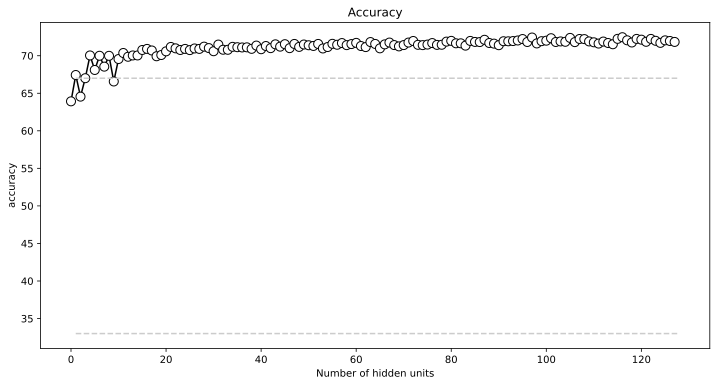

In [ ]:
# report accuracy
fig,ax = plt.subplots(1,figsize=(12,6))

ax.plot(accuracy_per_unit,'ko-',markerfacecolor='w',markersize=9)
ax.plot(numhiddens[[0,-1]],[33,33],'--',color=[.8,.8,.8])
ax.plot(numhiddens[[0,-1]],[67,67],'--',color=[.8,.8,.8])
ax.set_ylabel('accuracy')
ax.set_xlabel('Number of hidden units')
ax.set_title('Accuracy')
plt.show()